In [1]:
from warnings import simplefilter, filterwarnings
simplefilter('ignore')
filterwarnings('ignore')

# One Single Model Prediction

## Section 1: Data Preparation

### Import packages

In [2]:
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.statsforecast import StatsForecastAutoETS
from forecast_combine.forecast import Forecast

Importing plotly failed. Interactive plots will not work.


### Prepare data

<Axes: >

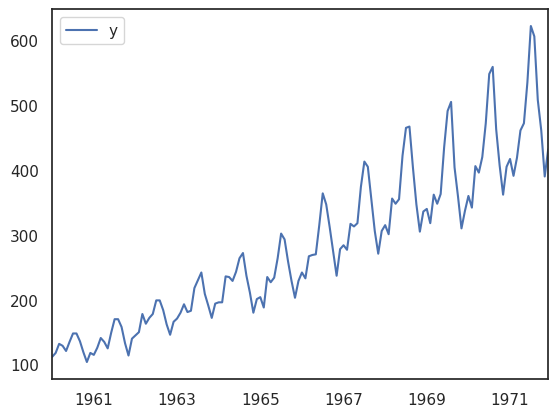

In [3]:
data = load_airline().rename('y').to_frame()
data.index = pd.date_range(start='1960-01-01', periods=len(data), freq='M')
data.plot()

## Section 2: Model Definition

In [4]:
model = StatsForecastAutoETS(season_length=12)

In [5]:
LF = Forecast(data = data,
            depvar_str='y',      
            exog_l= None,
            forecaster_name = 'AutoETS',
            forecaster= model,
            fh = 5,
            pct_initial_window = 0.75,
            step_length = 1, 
            freq = 'M')

In [6]:
LF.split_procedure_summary()

Number of Folds      : 32
Initial Window Size  : 108
Step Length          : 1
Forecast Horizon     : 5
First Cutoff         : 1968-12-31 00:00:00
Last Curoff          : 1971-07-31 00:00:00


{'Number of Folds': 32,
 'Initial Window Size': 108,
 'Step Length': 1,
 'Forecast Horizon': 5,
 'First Cutoff': Timestamp('1968-12-31 00:00:00'),
 'Last Curoff': Timestamp('1971-07-31 00:00:00')}

## Section 3: In-sample vs Out-Of-smaple

### Cross validation Procedure

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Insample vs Out-Of-Sample'}, ylabel='y'>)

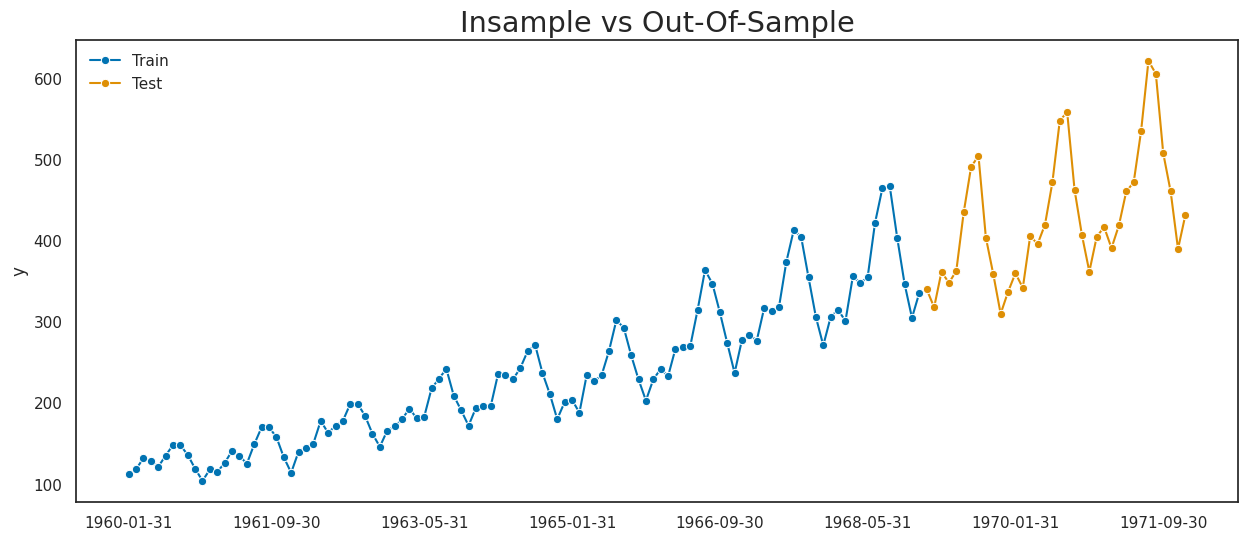

In [7]:
LF.plot.plot_train_test(
    labels = ['Train', 'Test'],
    title='Insample vs Out-Of-Sample')

<Axes: title={'center': 'Cross Validation Procedure'}, ylabel='Window number'>

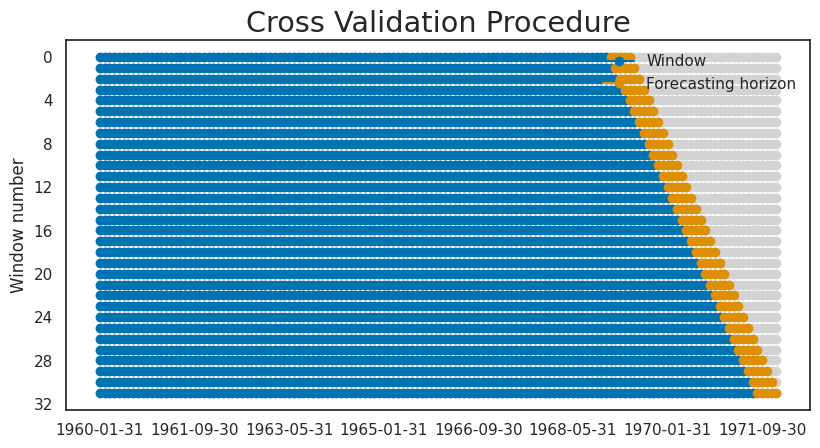

In [8]:
LF.plot.plot_cv_procedure(xlabel='')

### Fit

In [9]:
lf_fit= LF.fit(on='train')

In [10]:
lf_fit.insample_result_df

### In Sample Evaluation

In [11]:
pred = lf_fit.insample_predictions(nsample =200)
display(pred.head())

100%|██████████| 103/103 [00:00<00:00, 1155.70it/s]


,cutoff,horizon,index,y_pred,y_true,error,error_pct
0,1960-01-31,1,1960-02-29,111.053867,118.0,6.946133,0.058866
1,1960-01-31,2,1960-03-31,131.597243,132.0,0.402757,0.003051
2,1960-01-31,3,1960-04-30,126.908118,129.0,2.091882,0.016216
3,1960-01-31,4,1960-05-31,125.125660,121.0,-4.125660,0.034096
4,1960-01-31,5,1960-06-30,139.697422,135.0,-4.697422,0.034796


In [12]:
insample_perf_summary = lf_fit.insample_perf()
display(insample_perf_summary['cutoff'].head())
display(insample_perf_summary['horizon'].head())

,RMSE,MAE,MAPE,R2,MedianAE
cutoff,,,,,
1960-01-31,4.286579,3.652770,0.029405,0.562506,4.125660
1960-02-29,3.315624,2.937095,0.022183,0.859059,3.367757
1960-03-31,3.359963,3.112839,0.023304,0.899704,3.367757
1960-04-30,3.794843,3.587399,0.026627,0.856336,4.125660
1960-05-31,3.667985,3.463336,0.025699,0.882147,3.505345


,RMSE,MAE,MAPE,R2,MedianAE
horizon,,,,,
1,10.848503,8.398032,0.036538,0.982884,7.58114
2,10.829672,8.354775,0.036026,0.983374,7.58114
3,10.831602,8.371387,0.036056,0.983449,7.58114
4,10.832295,8.374706,0.035976,0.983316,7.58114
5,10.838262,8.388128,0.035804,0.983232,7.58114


(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'RMSE By cutoff'}>,
        <Axes: title={'center': 'RMSE By horizon'}>], dtype=object))

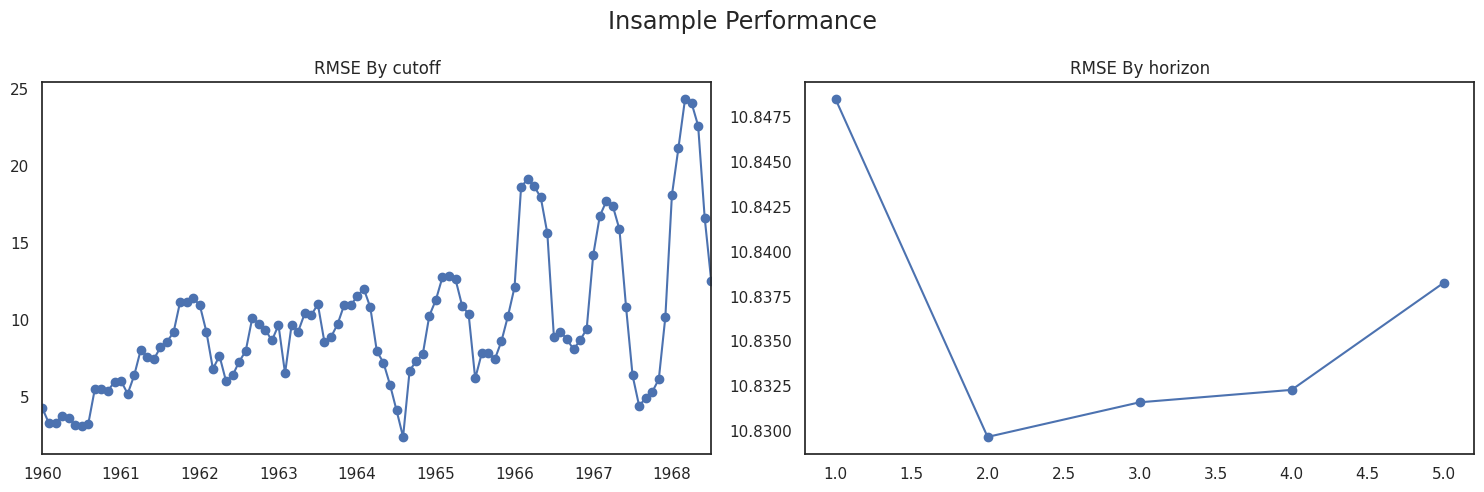

In [13]:
lf_fit.plot.plot_insample_performance(metric='RMSE')

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'MAPE By cutoff'}>,
        <Axes: title={'center': 'MAPE By horizon'}>], dtype=object))

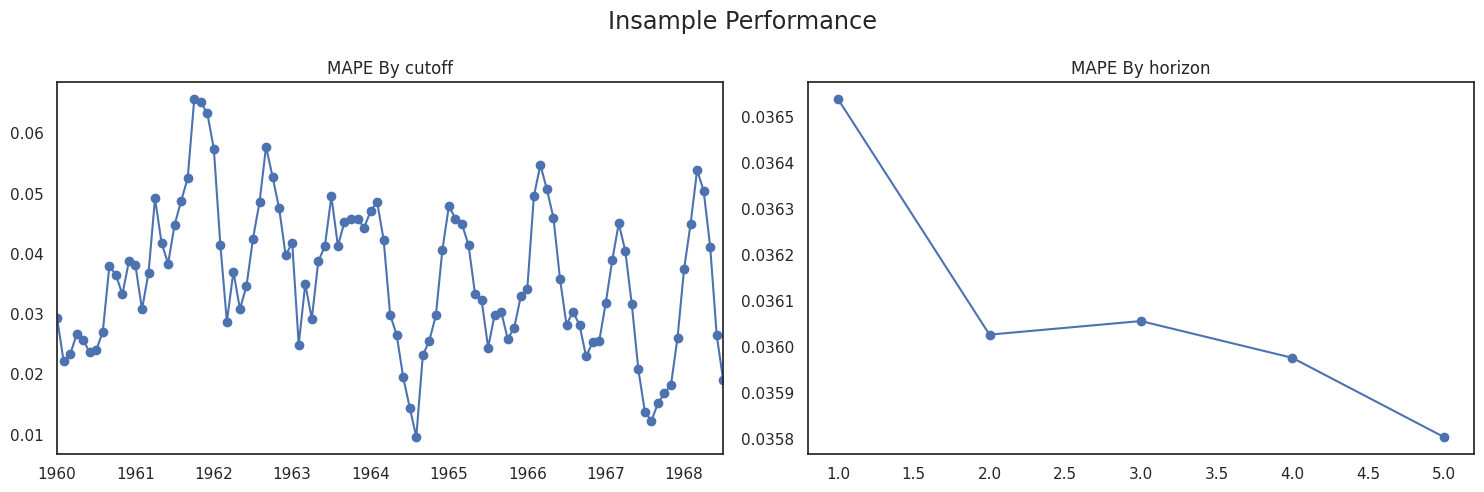

In [14]:
lf_fit.plot.plot_insample_performance(metric='MAPE')

### Out-Of-sample Evaluation

In [15]:
lf_eval= LF.evaluate()


Start AutoETS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ub

Evaluation completed in: 0.34 minutes


In [16]:
lf_eval.summary_results()

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
0,32,17.450796,0.384635,108,139,1968-12-31 00:00:00,1971-07-31 00:00:00,30.589516,27.138378,0.058201,0.516795,24.41697


In [17]:
lf_eval.summary_horizon()

,RMSE,MAE,MAPE,R2,MedianAE
horizon,,,,,
1,24.600849,20.103394,0.044684,0.908304,13.972764
2,30.893150,24.509864,0.053196,0.854304,16.339172
3,35.769426,28.135925,0.059819,0.792182,20.329706
4,39.393420,31.190632,0.065963,0.743546,25.933814
5,39.560484,31.752076,0.067344,0.730127,27.679685


<Axes: title={'center': 'Out of Sample Performance'}, ylabel='MAPE'>

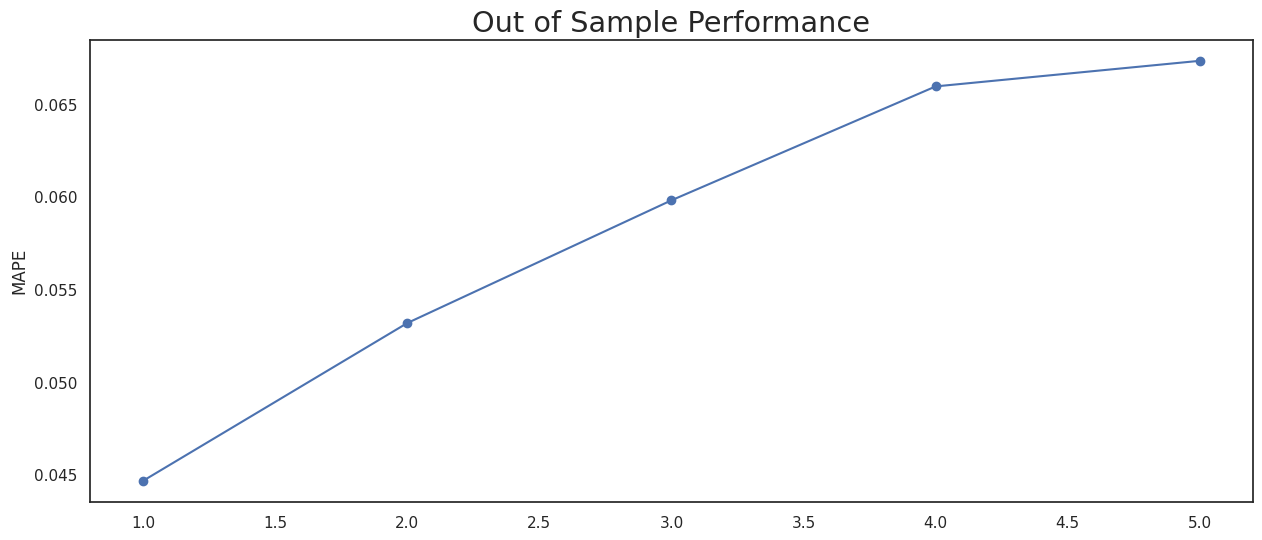

In [18]:
lf_eval.plot.plot_oos_score(score = 'MAPE')

<Axes: title={'center': 'Out of Sample Performance'}, ylabel='MAPE'>

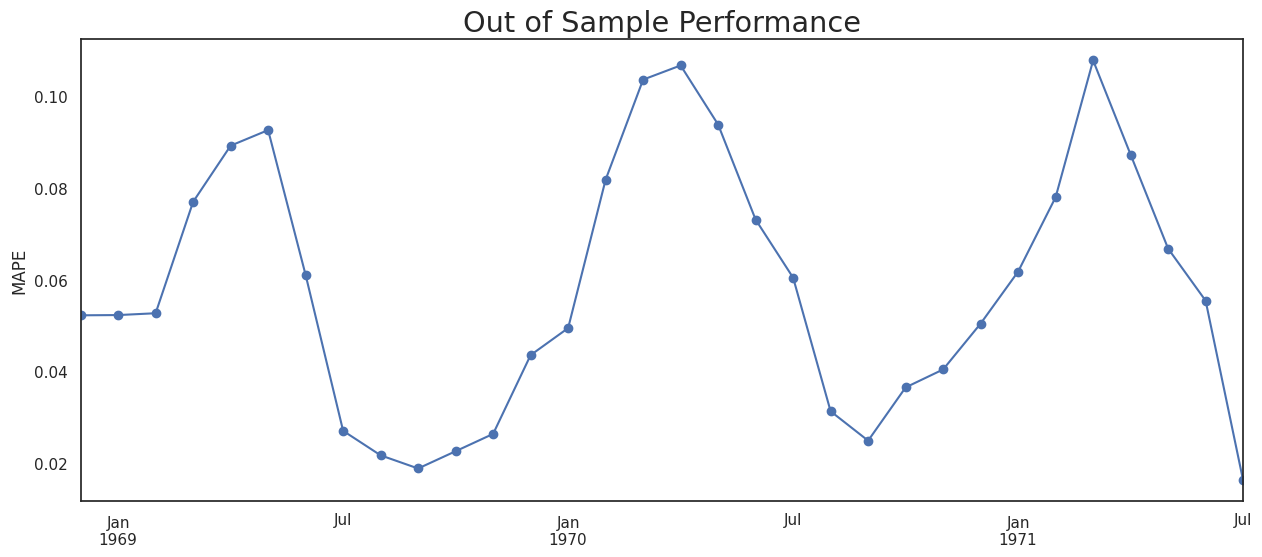

In [19]:
lf_eval.plot.plot_oos_score(score = 'MAPE', view='cutoff')

## Section 4: Generate predictions

In [24]:
# First Fit on all the sample
LF.fit(on ='all')
# Predict
y_pred, y_pred_ints = LF.predict()

(<Figure size 1300x500 with 1 Axes>,
 <Axes: title={'center': 'Prediction'}, ylabel='y'>)

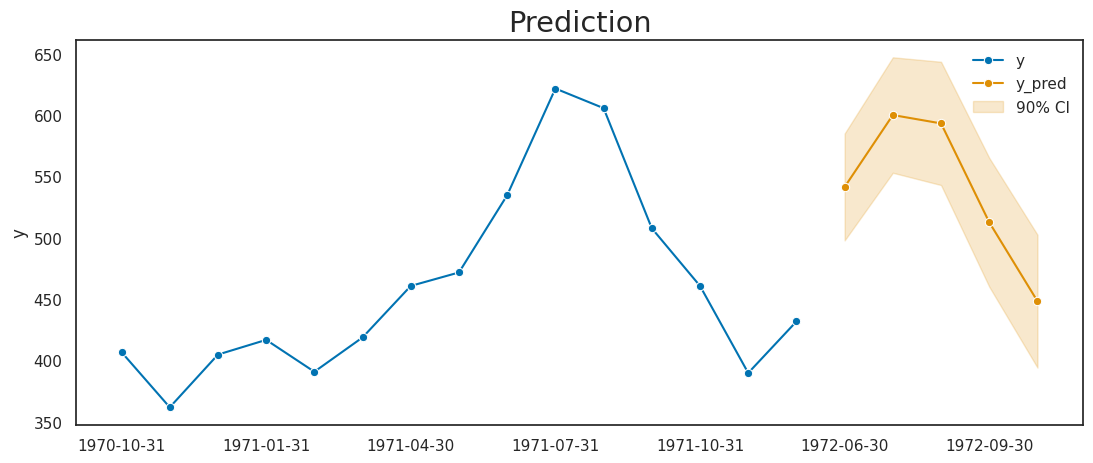

In [25]:
LF.plot.plot_prediction(y_pred, y_pred_ints, 
                        labels=['y', 'y_pred'], 
                        title = 'Prediction', 
                        figsize = (13,5))

### Section 5: Update Predictions when new data comes in
(Either with or without refitting the model)

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction'}, ylabel='y'>)

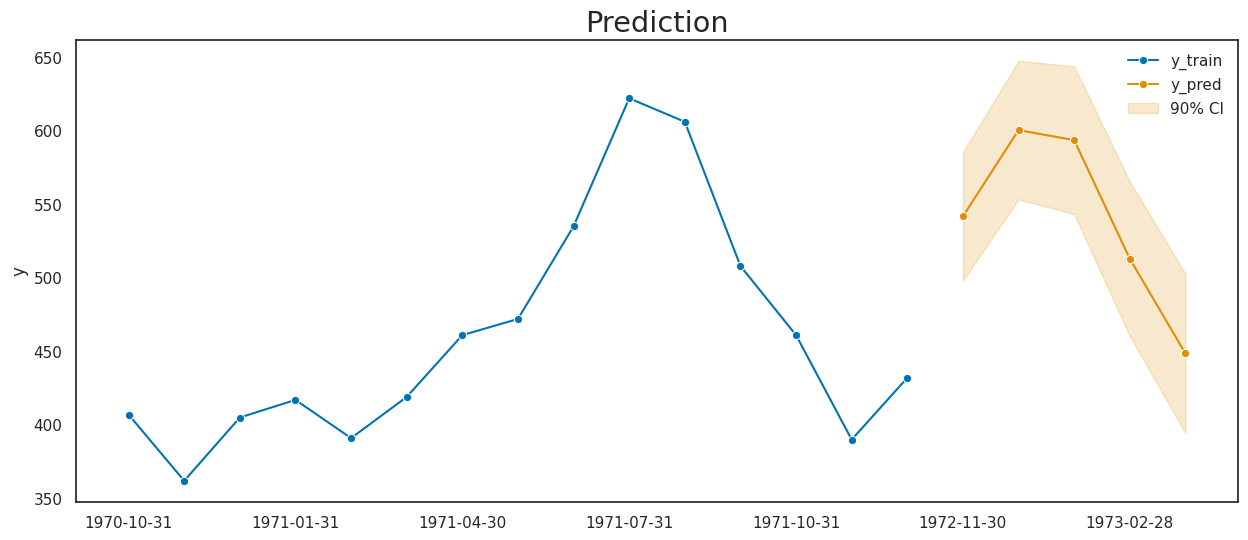

In [30]:
new_y = pd.concat([data.squeeze(), y_pred])
y_pred, y_pred_ints = LF.update(new_y = new_y, refit=False)
LF.plot.plot_prediction(y_pred, y_pred_ints)